In [1]:
import csv
import scipy
import numpy as np
import pandas as pd
import modred as mr
import itertools as it
from pydmd import DMD, DMDc
from numpy import savetxt
from scipy import integrate
from scipy.linalg import svd
import matplotlib.pyplot as plt
from math import e

### DMD

__DMD__  is a  purely data-driven method which finds the best fit linear model to approximate potentialy non-linear dynamics. 
In other words, DMD is a combo of Principal component analysis and Fourier transform

$X^{'} \simeq  AX,  $ 

*where X is the initial state matrix and $X^{'}$ is a state matrix shifted one step in time,and A (linear opertor) which explains the dynamics. *



__DMD__ approximates leading(dominant) eigenvalues of A without computing A. 
We predict the change of the system Without the control. 

Firs step to compute singular value decomposition 


(1)
U- dominant cohirent patterns of the dynamics (propal orthogonal decomposition) orginised in hierarhical order, so we need only 3 (?) as we will have only 3 actuators. 


$X=U\sum V^{*} \\
X^{'} = AU\sum V^{*}$



(2) we project A on U, so we have smaller matrix $\tilde{A}$



$U^{*}X^{'} V \sum^{-1} = U{*}AU = \tilde{A}$ 


(3)
eigenvalues of A


$\tilde{A}W = W \Lambda $

(4)
eigenvectors of A (from Kultz 2016): 


$\Phi=X^{'} V \sum^{-1}W$


Refferences: _Shmid 2010, Rowley, Mezlic et al. 2009, Tu, Rowley et al. 2014, Kutz, Brunton et al., 2016_


### DMD 

At firts for simplicit we modeled simulation as a one parameter g = g-z. 
Thus, 
g=6 == "no stimulation"
g=4 == "stimulation z=2"etc.



#### g=6

In [6]:
no_control_data = pd.read_csv("./three_nodes_data/three_nodes_data_g_6.csv").values
x = no_control_data[300:10000]
x_prime = no_control_data[301:10001, :]

In [7]:
# Compute POD
# num_modes = 3
# POD_res = mr.compute_POD_arrays_snaps_method(
#     x, list(mr.range(num_modes)))
# modes = POD_res.modes
# eigvals = POD_res.eigvals

In [8]:
#Compute SVD
U, S, V_transpose = svd(x)

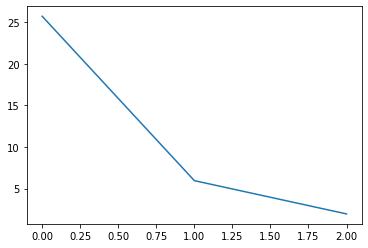

In [9]:
plt.plot(S)

In [67]:
x = no_control_data[300:10000]
#Compute SVD
U, S, V_transpose = svd(x)
plt.plot(S)
r=2 #number of modes based on the plot
U=U[:,:r] 
S = np.identity(2, dtype=int)*S[:r]
V_transpose = V_transpose[:,:r]

A = np.dot(V_transpose, np.linalg.inv(S))
A=np.dot(x_prime, A)
Atilde=np.dot(np.transpose(U),A)

[W, eigv] = np.linalg.eig(Atilde)

Phi = np.dot(np.linalg.inv(S),W)
Phi=np.dot(V_transpose, Phi)
Phi=np.dot(x_prime, Phi)

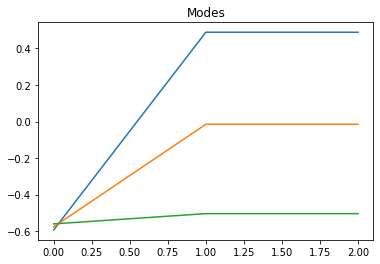

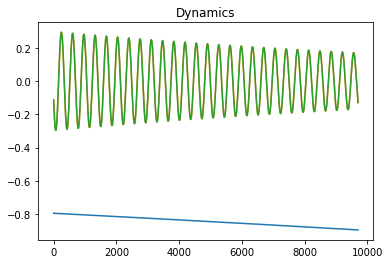

In [38]:
#same using pydmd package
dmd = DMD(svd_rank=3)
dmd.fit(x.T)

for mode in dmd.modes:
    plt.plot(mode.real.T)
    plt.title('Modes')
plt.show()

for dynamic in dmd.dynamics:
    plt.plot( dynamic.real)
    plt.title('Dynamics')
plt.show()

#### g=4

In [12]:
data = pd.read_csv("./three_nodes_data/three_nodes_data_g_4.csv").values
x = data[300:-1]
x_prime = data[301 :,]

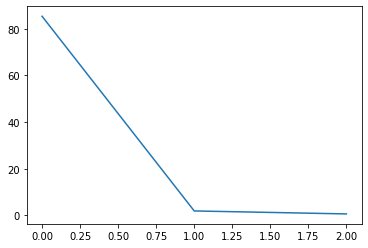

In [13]:
U, S, V_transpose = svd(x)
plt.plot(S)

In [14]:
r=2 #number of modes
U=U[:,:r] 
S = np.identity(2, dtype=int)*S[:r]
V_transpose = V_transpose[:,:r]

# Atilde = np.dot(np.transpose(U),x_prime,V_transpose,np.linalg.inv(S))

A = np.dot(V_transpose, np.linalg.inv(S))
A=np.dot(x_prime, A)
Atilde=np.dot(np.transpose(U),A)

[W, eigv] = np.linalg.eig(Atilde)

# Phi = x_prime*V_transpose*inv(S)*W)
Phi = np.dot(np.linalg.inv(S),W)
Phi=np.dot(V_transpose, Phi)
Phi=np.dot(x_prime, Phi)

#### g=2

In [17]:
data = pd.read_csv("./three_nodes_data/three_nodes_data_g_2.csv").values
x = data[300:10000]
x_prime = data[301:10001, :]

In [20]:
U, S, V_transpose = svd(x)

/Users/maria_p/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


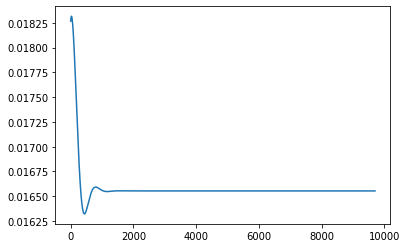

In [22]:
r=2 #number of modes
U=U[:,:r] 
S = np.identity(2, dtype=int)*S[:r]
V_transpose = V_transpose[:,:r]

# Atilde = np.dot(np.transpose(U),x_prime,V_transpose,np.linalg.inv(S))

A = np.dot(V_transpose, np.linalg.inv(S))
A=np.dot(x_prime, A)
Atilde=np.dot(np.transpose(U),A)

[W, eigv] = np.linalg.eig(Atilde)

# Phi = x_prime*V_transpose*inv(S)*W)
Phi = np.dot(np.linalg.inv(S),W)
Phi=np.dot(V_transpose, Phi)
Phi=np.dot(x_prime, Phi)

plt.plot(Phi)

# DMD with Control


__System__

\begin{equation}
X^{'}=AX + BY
\end{equation}

__We do not know the control matrix (_K_)__
\begin{equation}x_{k+1} = Ax_{k}+Bu_{k} \\
\end{equation}
__or__

\begin{equation}
u=Kx + \eta
\end{equation}


\begin{equation}X^{'}=\end{equation}

  \begin{bmatrix}
    A & B 
  \end{bmatrix}\begin{bmatrix}
    X \\
    Y \\
  \end{bmatrix} 


__We have to simultaneously solve for A and B.__

\begin{equation}
CL=A-B^{*}K 
\end{equation}

\begin{equation}
u=-K^{*}u
\end{equation}

We run a simulation with intermoitten 

In [31]:
data = pd.read_csv('./three_nodes_data/data_for_DMDc2.csv', delimiter=',')
data=data.values

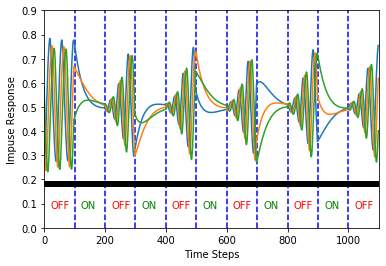

In [32]:
plt.plot(data[:,:3])
plt.xlabel("Time Steps")
plt.ylabel("Impuse Response")

plt.axis([0, 1100, 0, 0.9])
plt.vlines(np.arange(1,11)*100, 0,9, "blue", "--")
plt.hlines(0.18, 0, 1100,linewidth=6, color= "black")
for i in np.arange(120,1000,200):
    plt.annotate("ON",xy=(i,0.08), color="green")
for i in np.arange(20,1100,200):
    plt.annotate("OFF",xy=(i,0.08),color="red")
# for i in np.arange(0,1200,200):
#     plt.axvspan(xmin=i, xmax=i+100, color="gray")
# for i in np.arange(100,1200,200):
#     plt.axvspan(xmin=i, xmax=i+100)


In [33]:
x=data[:196]
u=np.repeat(data[1:197,3],3).reshape(196,3) #control input with shape [response_len; number of electrodes]
dmdc_on = DMDc(svd_rank=3)
dmdc_on.fit(x,u)

/Users/maria_p/opt/anaconda3/lib/python3.7/site-packages/pydmd/dmdbase.py:215: UserWarning: Input data matrix X has condition number 5.665016849529641e+32. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  .format(cond_number))


/Users/maria_p/opt/anaconda3/lib/python3.7/site-packages/pydmd/dmdbase.py:126: RuntimeWarning: invalid value encountered in log
  omega = old_div(np.log(self.eigs), self.original_time['dt'])


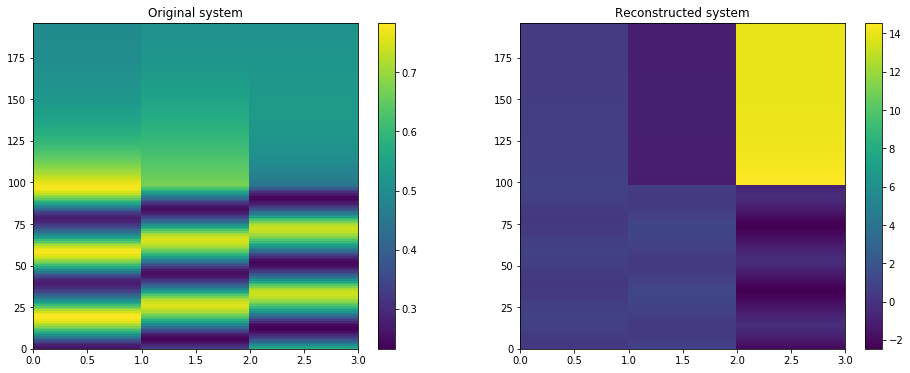

In [34]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.title('Original system')
plt.pcolor(x[:,:3])
plt.colorbar()

plt.subplot(122)
plt.title('Reconstructed system')
plt.pcolor(dmdc_on.reconstructed_data().real[:,:3])
plt.colorbar()

plt.show()

In [3]:
# #0ff period
# x = data[:100,:3]
# dmd_off = DMD(svd_rank=2)
# dmd_off.fit(x.T)

# for mode in dmd_off.modes:
#     plt.plot(mode.real.T)
#     plt.title('Modes')
# plt.show()

# for dynamic in dmd_off.dynamics:
#     plt.plot( dynamic.real)
#     plt.title('Dynamics')
# plt.show()

In [4]:
# plt.figure()
# plt.pcolor(dmd_off.reconstructed_data.T.real)
# plt.colorbar()
# plt.show()

In [6]:
# for eig in dmd_off.eigs:
#     print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

# # dmd_off.plot_eigs(show_axes=True, show_unit_circle=True)

In [7]:
# x = pd.read_csv("three_nodes_data_g_2.csv")
# x["4"] = np.zeros((len(x),1))
# x = x.values[800:996]
# plt.plot(x)

In [685]:
# "The mapping for DMDc projects a high-dimensional set of observables on to a lower-dimensional subspace."

# x = pd.read_csv("three_nodes_data_g_2.csv").values[:196]



# dmdc_on = DMDc(svd_rank=-1)
# dmdc_on.fit(x,u)
# for eig in dmdc_on.eigs:
#     print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

# dmdc_on.plot_eigs(show_axes=True, show_unit_circle=True)

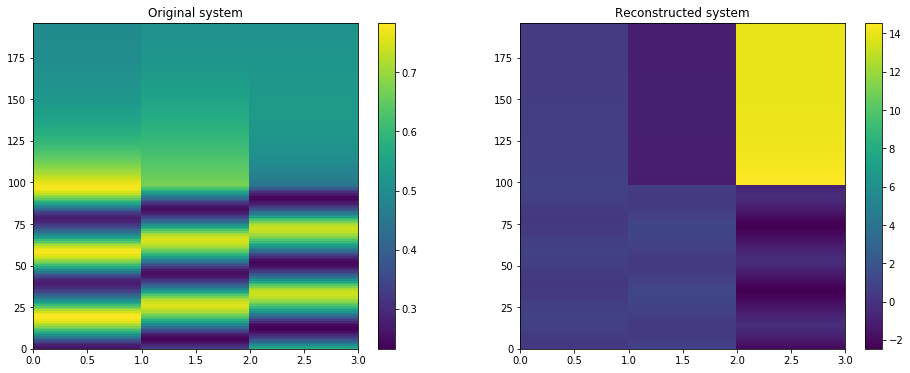

In [35]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.title('Original system')
plt.pcolor(x[:,:3])
plt.colorbar()

plt.subplot(122)
plt.title('Reconstructed system')
plt.pcolor(dmdc_on.reconstructed_data().real[:,:3])
plt.colorbar()

plt.show()


In [36]:
def apply_control(signal,u_init, A_tilde, B):
#     signal_truncated = np.matmul(C.T,signal)
    output=np.matmul(signal,A_tilde) + np.matmul(B, u_init)
    return output

In [37]:
data_off = np.repeat(data[2:100,:3],2,axis=0)
A_tilde = dmdc_on.atilde
B=dmdc_on.B
C = dmdc_on.basis
u_new=np.reshape(np.random.rand(196*3), [196,3])
print({"B_shape":np.shape(B), "data shape": np.shape(data_off), "A_shape": np.shape(A_tilde), "C":np.shape(C) })

{'B_shape': (196, 196), 'data shape': (196, 3), 'A_shape': (3, 3), 'C': (196, 3)}


In [38]:
new = apply_control(data_off, u_new,A_tilde, B)

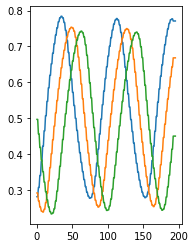

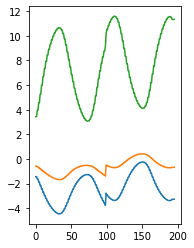

In [39]:
plt.subplot(122)
plt.plot(data_off)
plt.figure()
plt.subplot(121)
plt.plot(new)
plt.show()

In [281]:
#DMD with control
dmdc_not_trancated = DMDc(svd_rank=-1)
dmdc_not_trancated .fit(x, u)

/Users/maria_p/opt/anaconda3/lib/python3.7/site-packages/pydmd/dmdbase.py:215: UserWarning: Input data matrix X has condition number 3.722434222406424e+16. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  .format(cond_number))


In [285]:
atilde = dmdc_not_trancated.atilde

control_matrix = dmdc_not_trancated.B

In [288]:
np.shape(control_matrix)

(1098, 1098)

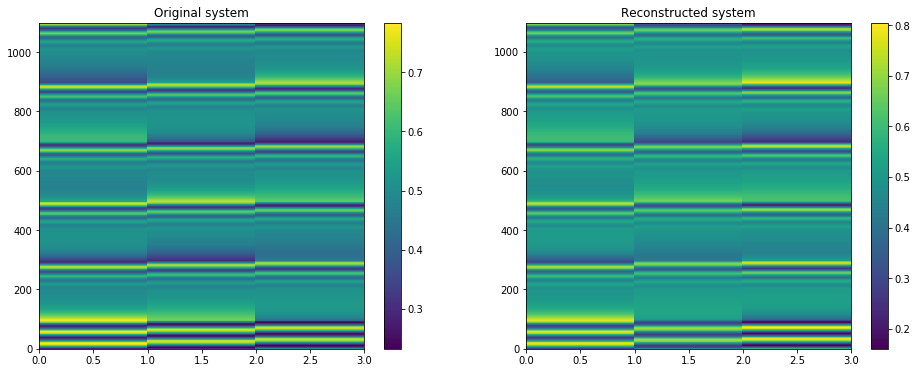

In [224]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.title('Original system')
plt.pcolor(data[:,:3])
plt.colorbar()

plt.subplot(122)
plt.title('Reconstructed system')
plt.pcolor(dmdc_not_trancated.reconstructed_data().real)
plt.colorbar()

plt.show()

In [266]:
dmdc_not_trancated.eigs

array([0.03520453, 0.48777748])

Eigenvalue 0.035204526772736666: distance from unit circle 0.9987606412947077
Eigenvalue 0.48777748062176096: distance from unit circle 0.7620731293982876


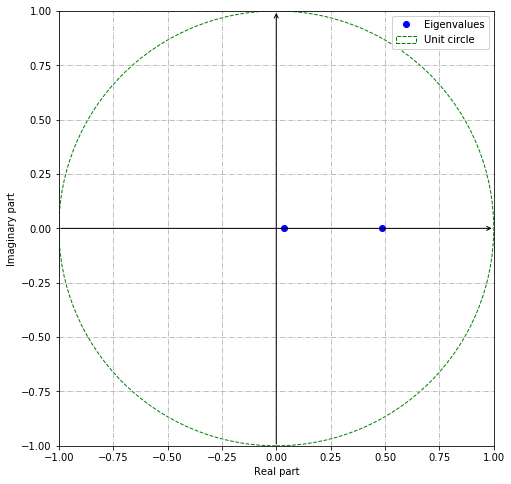

In [265]:
for eig in dmdc_not_trancated.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmdc_not_trancated.plot_eigs(show_axes=True, show_unit_circle=True)

In [289]:
#DMD with control with 2 eigenvectors
dmdc_rank_2 = DMDc(svd_rank=2)
dmdc_rank_2.fit(x, u)

/Users/maria_p/opt/anaconda3/lib/python3.7/site-packages/pydmd/dmdbase.py:215: UserWarning: Input data matrix X has condition number 3.722434222406424e+16. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  .format(cond_number))


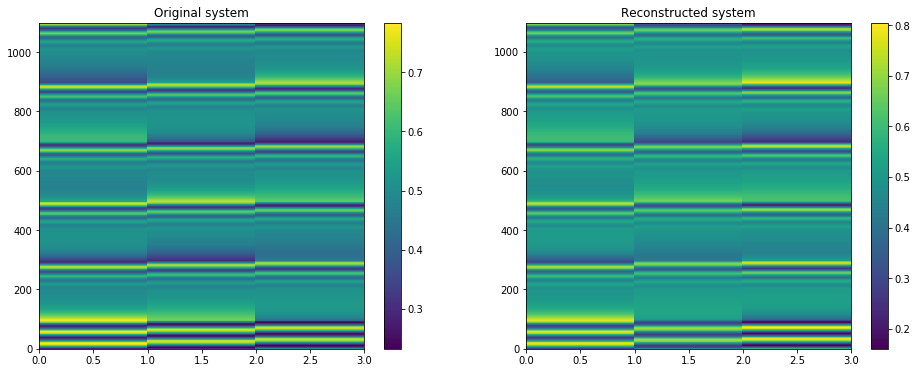

In [290]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.title('Original system')
plt.pcolor(data[:,:3])
plt.colorbar()

plt.subplot(122)
plt.title('Reconstructed system')
plt.pcolor(dmdc_rank_2.reconstructed_data().real)
plt.colorbar()

plt.show()

Eigenvalue 0.035204526772736666: distance from unit circle 0.9987606412947077
Eigenvalue 0.48777748062176096: distance from unit circle 0.7620731293982876


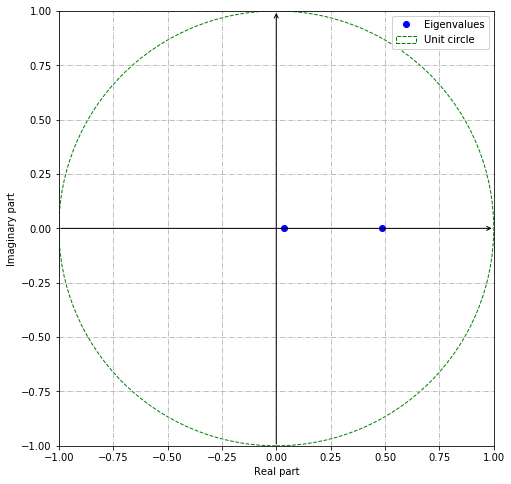

In [292]:
for eig in dmdc_rank_2.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmdc_rank_2.plot_eigs(show_axes=True, show_unit_circle=True)

In [293]:
dmdc_rank_2.eigs==dmdc_not_trancated.eigs

array([ True,  True])

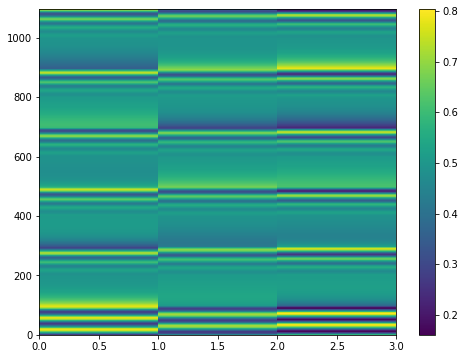

In [301]:
new_u = np.exp(u)

plt.figure(figsize=(8,6))
plt.pcolor(dmdc_rank_2.reconstructed_data(u).real)
plt.colorbar()
plt.show()

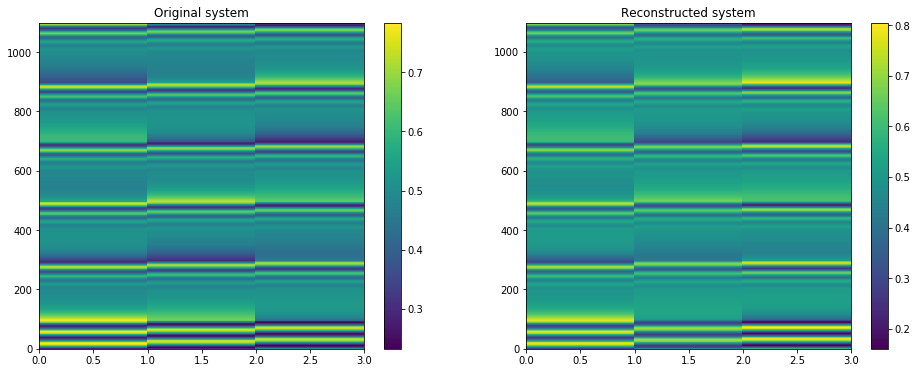

In [299]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.title('Original system')
plt.pcolor(data[:,:3])
plt.colorbar()

plt.subplot(122)
plt.title('Reconstructed system')
plt.pcolor(dmdc_rank_2.reconstructed_data(u).real)
plt.colorbar()

plt.show()


In [517]:
def create_system(n, m):
    A = scipy.linalg.helmert(n, True)
    B = np.random.rand(n, n)-.5
    x0 = np.array([0.25]*n)
    u = np.random.rand(n, m+1)-.5
    snapshots = [x0]
    for i in range(m-1):
        snapshots.append(A.dot(snapshots[i])+B.dot(u[:, i]))
    snapshots = np.array(snapshots).T
    return {'snapshots': snapshots, 'u': u, 'B': B, 'A': A}

In [518]:
s = create_system(25, 10)

In [519]:
dmdc = DMDc(svd_rank=-1)
dmdc.fit(s['u'],s['snapshots'])

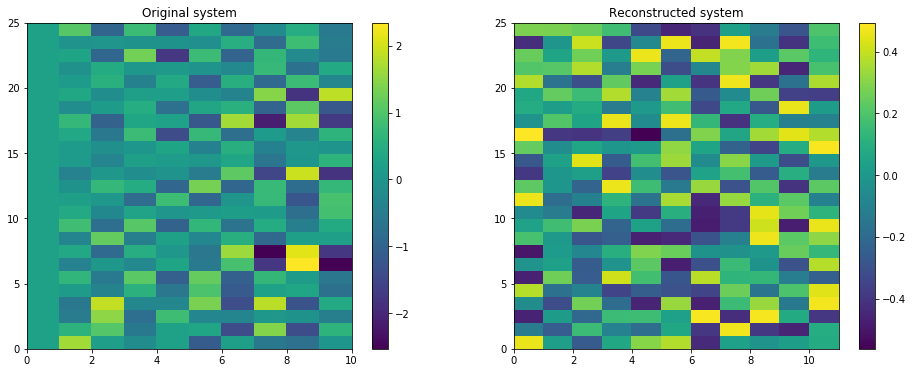

In [520]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.title('Original system')
plt.pcolor(s['snapshots'].real)
plt.colorbar()

plt.subplot(122)
plt.title('Reconstructed system')
plt.pcolor(dmdc.reconstructed_data().real)
plt.colorbar()

plt.show()

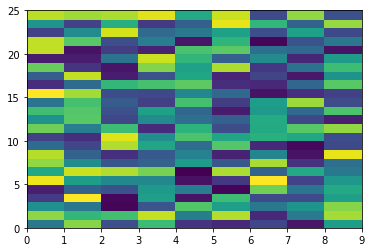

In [514]:
plt.pcolor(s['u'])

In [326]:
# def moving_window(data, length, step=1):
#     streams = it.tee(data, length)
# #     return zip(*[it.islice(stream, i, None, step*length)
#                  for stream, i in zip(streams, it.count(step=step))])

In [2]:
# # for i in range(len(data[:,1])):
# x_=list(moving_window(data, 3,step=))
# x_=np.asarray(x_)
# print(x_)   